# cmip Impacts by Event Type

This file makes lots of contour plots for rainfall and temperature anomalies under different individal and compound event types



In [2]:
import xarray
import numpy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


In [1]:
#import my functions
import utils._modelDefinitions as _model
%run helpers/impactPlots.ipynb


In [9]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
indexSet='ecCombinedDmiSam'

# Import Data

Import events

In [4]:
allCompounds=xarray.open_dataset('results/cmip6Compounds.nc').sel(experiment='ssp585',year=slice(1850,2099),drop=True)

In [5]:
#List of events to plot
eventsList=[
    #'everything',
    #'no',
    #'noFirePos', 
    #'enso','iod','sam', 
    *allCompounds.pairs, 
    'all3'
]
eventsList

['enso+iod', 'enso+sam', 'iod+sam', 'all3']

Import seasonal impacts

In [6]:
prXr=xarray.open_dataset('results/cmip6PrXr.nc')
detrendTsXr=xarray.open_dataset('results/cmip6DetrendTsXr.nc')


# Impact plots for compounds events

For:
- fire promoting and not promoting, 
- in each season, 
- for each combination of compound events,

plot mean rainfall and temperature anomalies

Fire:pos
winter


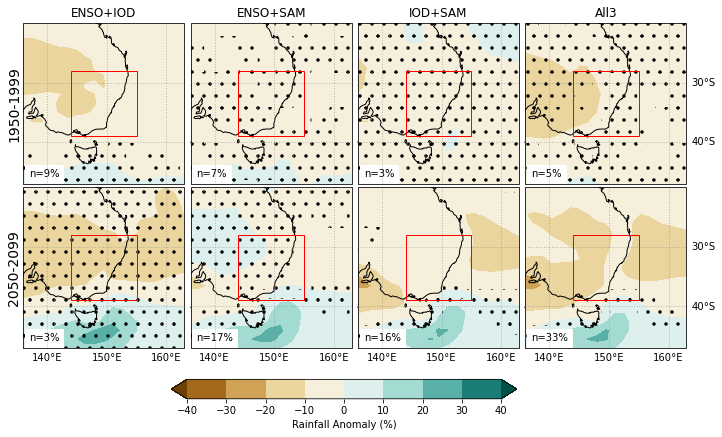

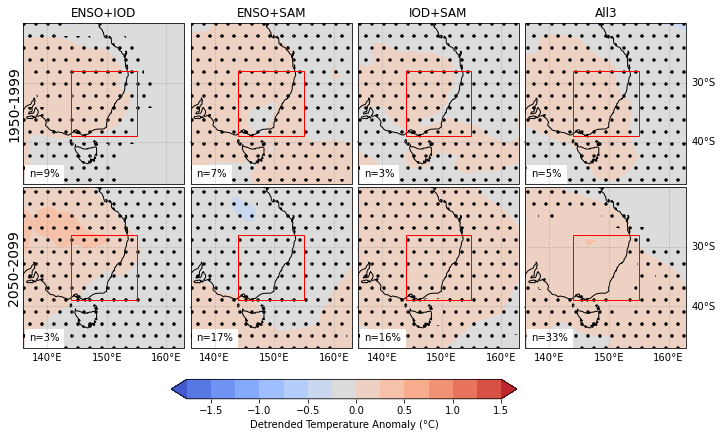

summer


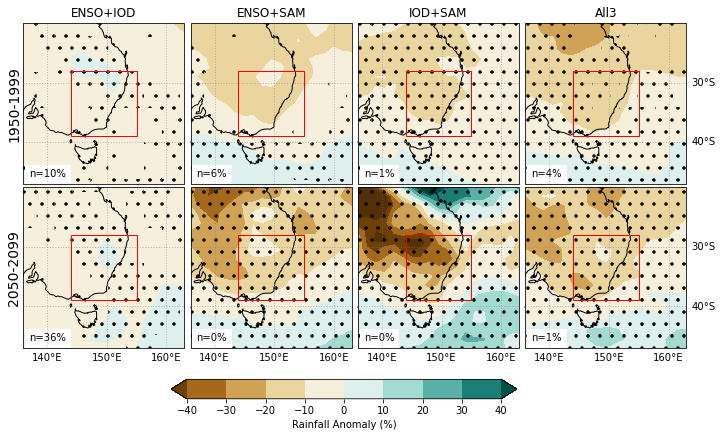

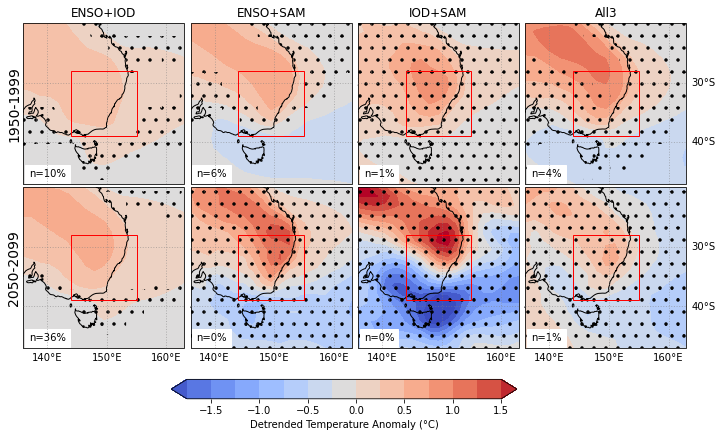

Fire:neg
winter


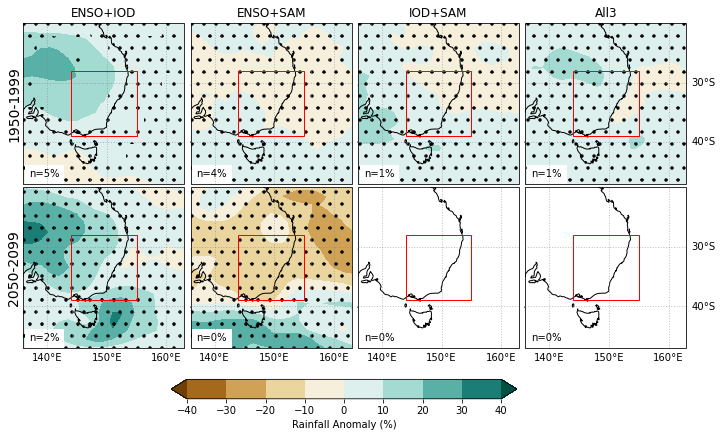

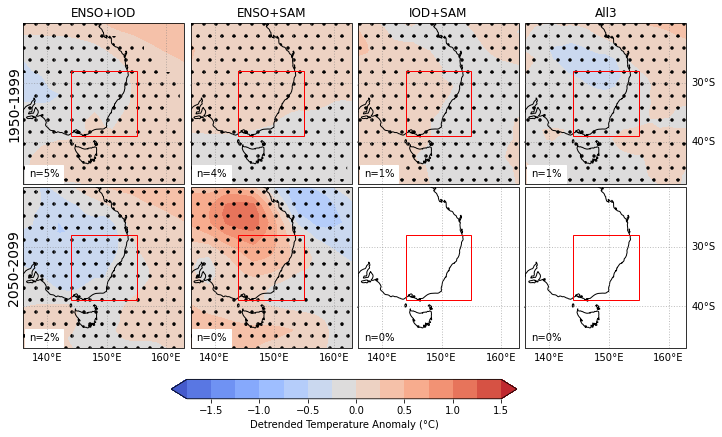

summer


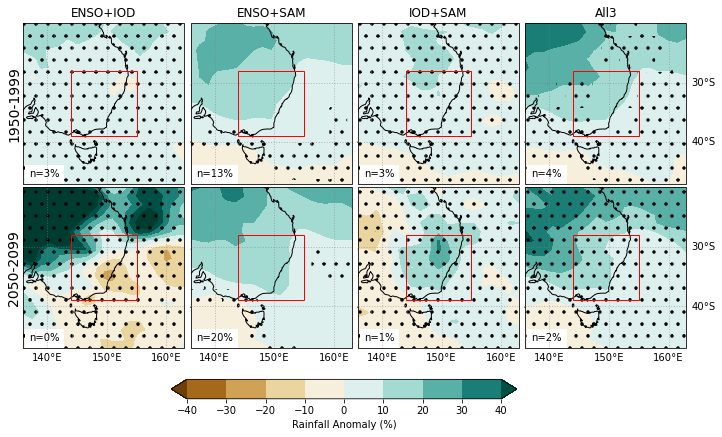

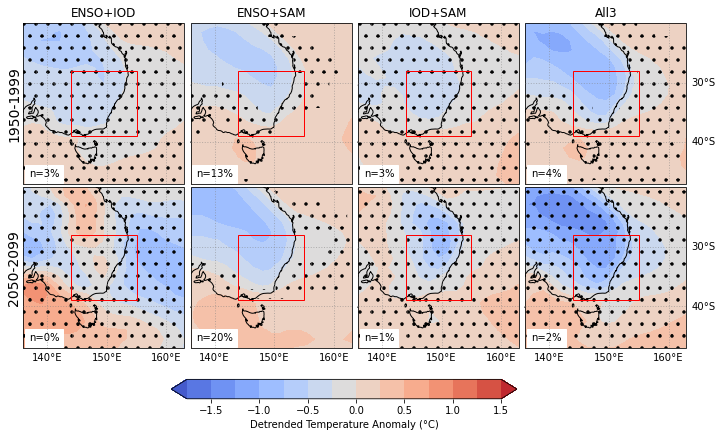

In [10]:
%run helpers/impactPlots.ipynb
resultsDir='figures/cmipCompoundImpact'+indexSet.capitalize()+'/'


for iFire in ['pos','neg']:
    print('Fire:'+iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)
        axs=multiPlotter(
            prXr[iSeason.capitalize()+' Rain'], #sourceData
            allCompounds[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, drop=True), #masks for event types
            eventsList, #names of event types
            cbarLabel='Rainfall Anomaly (%)'
        )
        axs[0].set_title('ENSO+IOD')
        axs[1].set_title('ENSO+SAM')
        axs[2].set_title('IOD+SAM')
        axs[3].set_title('All3')
        plt.savefig(
            resultsDir
            +iFire
            +iSeason.capitalize()
            +indexSet.capitalize()
            +'Rain.pdf',
            bbox_inches='tight'
        )
        plt.show()
        
        axs=multiPlotter(
            detrendTsXr[iSeason.capitalize()+' Temp'],
            allCompounds[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, drop=True), 
            eventsList,
            cbarLabel='Detrended Temperature Anomaly (°C)'
        )
        axs[0].set_title('ENSO+IOD')
        axs[1].set_title('ENSO+SAM')
        axs[2].set_title('IOD+SAM')
        axs[3].set_title('All3')
        plt.savefig(
            resultsDir
            +iFire
            +iSeason.capitalize()
            +indexSet.capitalize()
            +'Temp.pdf',
            bbox_inches='tight'
        )
        plt.show()

# Now pair them by how the frequencies change

In [22]:
%run helpers/impactPlots.ipynb

In [78]:
def singleAnomWithStipling(da, iComp, iSeason, iImpact='Rain'):
    
    season=iSeason.capitalize() +' '+ iImpact
    
    plotCond = da.sel(compound=iComp,drop=True)
    if iImpact=='Rain':
        toPlot = prXr[season].where(plotCond)
    elif iImpact=='Temp':
        toPlot = detrendTsXr[season].where(plotCond)
    cs, gl=plotAnom(toPlot.mean(['year','model']), ax)
    plotStipling(toPlot.mean('year'),ax)

    plt.xlim([136,163])
    plt.ylim([-47,-20])

    #This is the number of events. Because dataset is well-curated, we can use the count from one position to be the count for everything
    nEvents=(
        toPlot.isel(lon=17,lat=15).count()
        /(50*37)
        *100
    ).values
    ax.text(
        0.035,0.045,
        "n="+f'{nEvents:.0f}'+'%', 
        transform=ax.transAxes, 
        backgroundcolor='white',
        zorder=2
    )
    
    return cs, gl


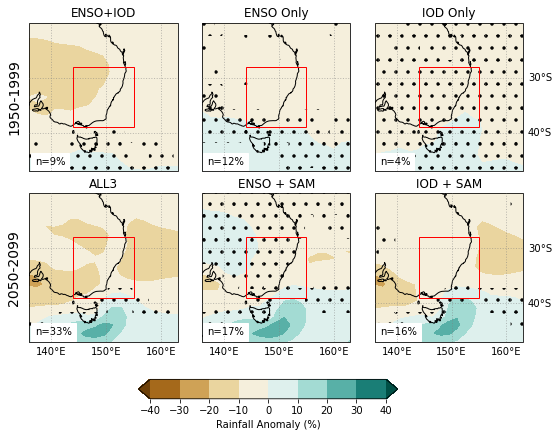

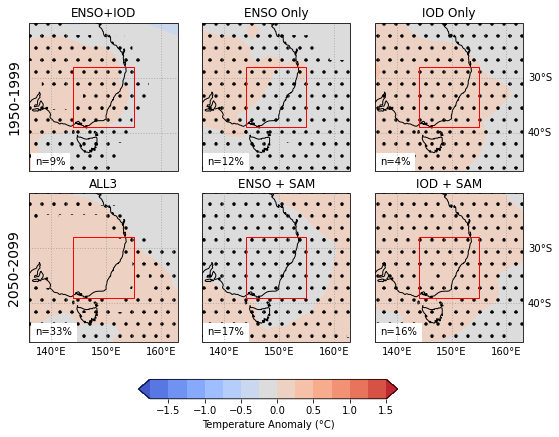

In [52]:
import matplotlib.cm as cm
import matplotlib.colorbar as cb
for iImpact in ['Rain','Temp']:
    nRows=2
    nCols=3

    fig=plt.figure(figsize=(nCols*3,nRows*4+1))

    #First row is years 1950 to 1999
    with allCompounds[indexSet+'winter'].sel(year=slice(1950,1999),fire='pos',drop=True) as firstRow:

        #First cell is ENSO+IOD
        ax=plt.subplot(nRows+1,nCols,1,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(firstRow,'enso+iod','winter',iImpact)
        ax.set_title('ENSO+IOD')
        gl.bottom_labels=False
        gl.right_labels=False

        #in the first column, put a y-label
        ax.text(
            -0.15, 0.5,  #xy relative to bottom left of axis
            str('1950-1999'), #yearRange
            rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
        )

        #2nd cell is ENSO only
        ax=plt.subplot(3,3,2,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(firstRow,'enso','winter',iImpact)
        ax.set_title('ENSO Only')
        gl.bottom_labels=False
        gl.right_labels=False

        #3rd cell is IOD only
        ax=plt.subplot(3,3,3,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(firstRow,'iod','winter',iImpact)
        ax.set_title('IOD Only')
        gl.bottom_labels=False

    #Second row is years 2050 to 2099
    with allCompounds[indexSet+'winter'].sel(year=slice(2050,2099),fire='pos',drop=True) as secondRow:
        #First cell is All3
        ax=plt.subplot(3,3,4,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(secondRow,'all3','winter',iImpact)
        ax.set_title('ALL3')
        gl.right_labels=False
        #in the first column, put a y-label
        ax.text(
            -0.15, 0.5,  #xy relative to bottom left of axis
            str('2050-2099'), #yearRange
            rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
        )

        #2nd cell is ENSO + SAM only
        ax=plt.subplot(3,3,5,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(secondRow,'enso+sam','winter',iImpact)
        ax.set_title('ENSO + SAM')
        gl.right_labels=False

        #3rd cell is IOD only
        ax=plt.subplot(3,3,6,projection=ccrs.PlateCarree())
        cs,gl = singleAnomWithStipling(secondRow,'iod+sam','winter',iImpact)
        ax.set_title('IOD + SAM')

    # add some space between rows
    plt.subplots_adjust(hspace=0.15, wspace=0.1)

    if iImpact=='Rain':
        label = 'Rainfall Anomaly (%)'
    elif iImpact=='Temp':
        label = ' Detrended Temperature Anomaly (°C)'
    
    #put a color bar on
    ax=fig.add_axes([0.3,0.3,0.4,0.03])
    cbar=plt.colorbar(
        cm.ScalarMappable(cs.norm,cs.cmap),
        orientation='horizontal', 
        cax=ax, 
        extend='both', 
        boundaries=cs.get_array(), 
        label=label
    )

    plt.savefig('figures/curatedImpactPlots/cmipDryWinter'+iImpact+'.pdf')

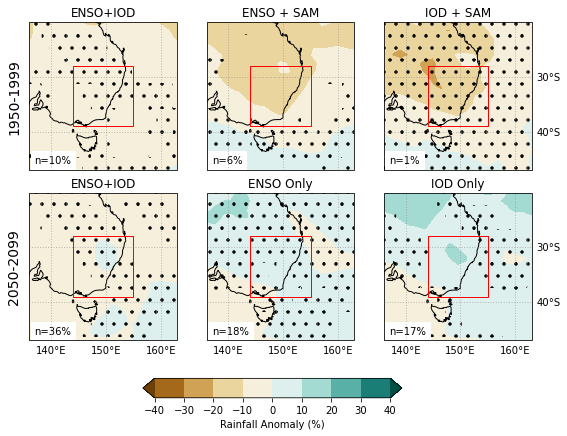

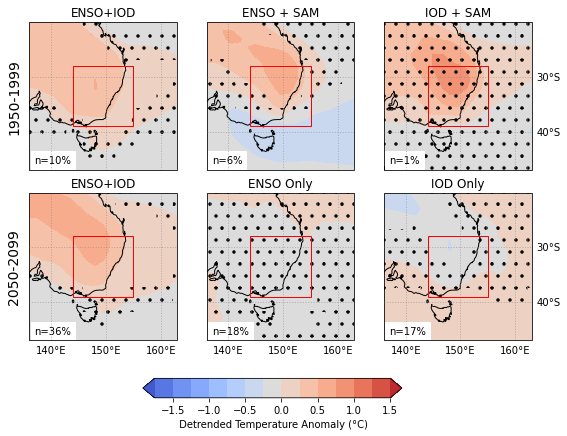

In [58]:
import matplotlib.cm as cm
import matplotlib.colorbar as cb
for iImpact in ['Rain','Temp']:

    nRows=2
    nCols=3
    fig=plt.figure(figsize=(nCols*3,nRows*4+1))

    #First row is years 1950 to 1999
    with allCompounds[indexSet+'summer'].sel(year=slice(1950,1999),fire='pos',drop=True) as firstRow:

        #First cell is ENSO+IOD
        ax=plt.subplot(nRows+1,nCols,1,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(firstRow,'enso+iod','summer',iImpact)
        ax.set_title('ENSO+IOD')
        gl.bottom_labels=False
        gl.right_labels=False

        #in the first column, put a y-label
        ax.text(
            -0.15, 0.5,  #xy relative to bottom left of axis
            str('1950-1999'), #yearRange
            rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
        )

        #2nd cell is ENSO only
        ax=plt.subplot(nRows+1,nCols,2,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(firstRow,'enso+sam','summer',iImpact)
        ax.set_title('ENSO + SAM')
        gl.bottom_labels=False
        gl.right_labels=False


        #3rd cell is IOD only
        ax=plt.subplot(nRows+1,nCols,3,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(firstRow,'iod+sam','summer',iImpact)
        ax.set_title('IOD + SAM')
        gl.bottom_labels=False


    #Second row is years 2050 to 2099
    with allCompounds[indexSet+'summer'].sel(year=slice(2050,2099),fire='pos',drop=True) as secondRow:
        #First cell is All3
        ax=plt.subplot(nRows+1,nCols,nCols+1,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(secondRow,'enso+iod','summer',iImpact)
        ax.set_title('ENSO+IOD')
        gl.right_labels=False


        #in the first column, put a y-label
        ax.text(
            -0.15, 0.5,  #xy relative to bottom left of axis
            str('2050-2099'), #yearRange
            rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
        )

        #2nd cell is ENSO + SAM only
        ax=plt.subplot(nRows+1,nCols,nCols+2,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(secondRow,'enso','summer',iImpact)
        ax.set_title('ENSO Only')
        gl.right_labels=False

        #3rd cell is IOD only
        ax=plt.subplot(nRows+1,nCols,nCols+3,projection=ccrs.PlateCarree())
        cs,gl= singleAnomWithStipling(secondRow,'iod','summer',iImpact)
        ax.set_title('IOD Only')

    # add some space between rows
    plt.subplots_adjust(hspace=0.15)

    if iImpact=='Rain':
        label = 'Rainfall Anomaly (%)'
    elif iImpact=='Temp':
        label = ' Detrended Temperature Anomaly (°C)'
    
    #put a color bar on
    ax=fig.add_axes([0.3,0.3,0.4,0.03])
    cbar=plt.colorbar(
        cm.ScalarMappable(cs.norm,cs.cmap),
        orientation='horizontal', 
        cax=ax, 
        extend='both', 
        boundaries=cs.get_array(), 
        label = label
    )

    plt.savefig('figures/curatedImpactPlots/cmipDrySummer'+iImpact+'.pdf')

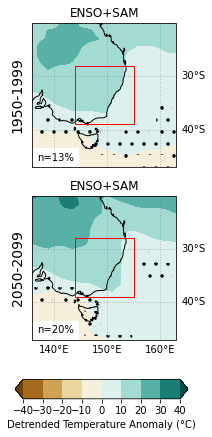

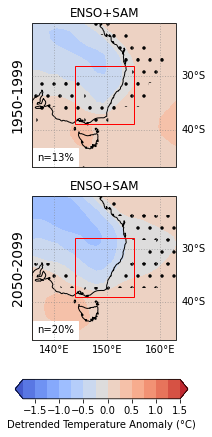

In [86]:
import matplotlib.cm as cm
import matplotlib.colorbar as cb

for iImpact in ['Rain','Temp']:

    fig=plt.figure(figsize=(3,9))

    #First row is years 1950 to 1999
    with allCompounds[indexSet+'summer'].sel(year=slice(1950,1999),fire='neg',drop=True) as firstRow:

        ax=plt.subplot(3,1,1,projection=ccrs.PlateCarree())
        cs,gl=singleAnomWithStipling(firstRow,'enso+sam','summer',iImpact)
        ax.set_title('ENSO+SAM')
        gl.bottom_labels=False

        #in the first column, put a y-label
        ax.text(
            -0.15, 0.5,  #xy relative to bottom left of axis
            str('1950-1999'), #yearRange
            rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
        )

    #Second row is years 2050 to 2099
    with allCompounds[indexSet+'summer'].sel(year=slice(2050,2099),fire='neg',drop=True) as secondRow:
        #First cell is All3
        ax=plt.subplot(3,1,2,projection=ccrs.PlateCarree())
        cs,gl=singleAnomWithStipling(secondRow,'enso+sam','summer',iImpact)
        ax.set_title('ENSO+SAM')

        #in the first column, put a y-label
        ax.text(
            -0.15, 0.5,  #xy relative to bottom left of axis
            str('2050-2099'), #yearRange
            rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
        )


    # add some space between rows
    plt.subplots_adjust(hspace=0.2)

    #put a color bar on
    ax=fig.add_axes([0.1,0.3,0.8,0.03])
    cbar=plt.colorbar(
        cm.ScalarMappable(cs.norm,cs.cmap),
        orientation='horizontal', 
        cax=ax, 
        extend='both', 
        boundaries=cs.get_array(), 
        label = 'Detrended Temperature Anomaly (°C)'
    )

    plt.savefig('figures/curatedImpactPlots/cmipWetSummer'+iImpact+'.pdf')

# ENSO comparisons

pos
winter


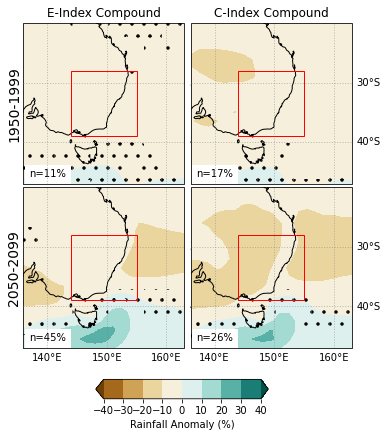

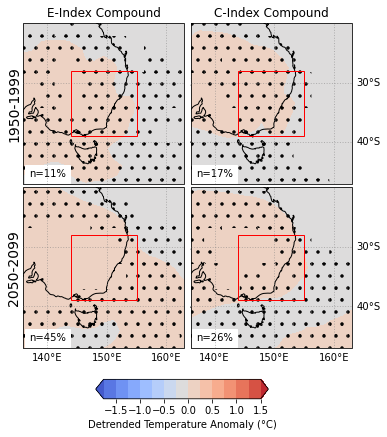

summer


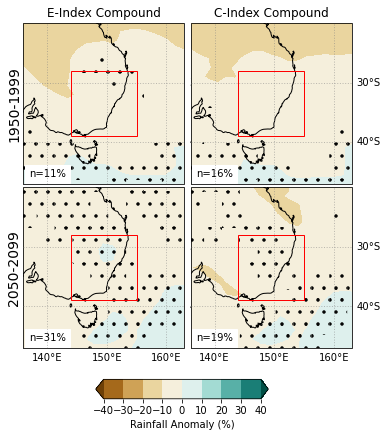

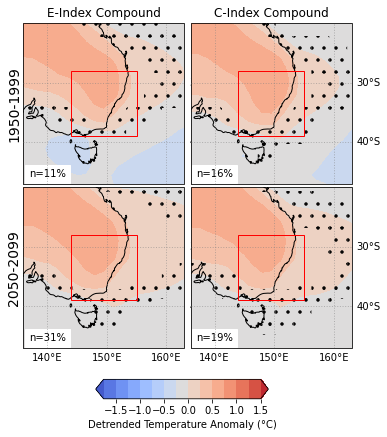

In [9]:
%run helpers/impactPlots.ipynb
for iFire in ['pos']:#,'neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
            print(iSeason)

            axs=multiPlotter(
                prXr[iSeason.capitalize()+' Rain'], #sourceData
                allCompounds[
                    ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason]
                ].sel(fire=iFire,compound=['enso+iod','enso+sam','all3'],drop=True).any('compound'), #masks for event types
                ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason],
                cbarLabel='Rainfall Anomaly (%)'
            )
            axs[0].set_title('E-Index Compound')
            axs[1].set_title('C-Index Compound')


            plt.savefig('figures/'+iFire+iSeason.capitalize()+'EvsCpRain.pdf')
            plt.show()

            axs=multiPlotter(
                detrendTsXr[iSeason.capitalize()+' Temp'], #sourceData
                allCompounds[
                    ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason]
                ].sel(fire=iFire,compound=['enso+iod','enso+sam','all3'],drop=True).any('compound'), #masks for event types
                ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason],
                cbarLabel='Detrended Temperature Anomaly (°C)'
            )
            axs[0].set_title('E-Index Compound')
            axs[1].set_title('C-Index Compound')

            plt.savefig('figures/'+iFire+iSeason.capitalize()+'EvsCpTemp.pdf')
            plt.show()


neg
winter


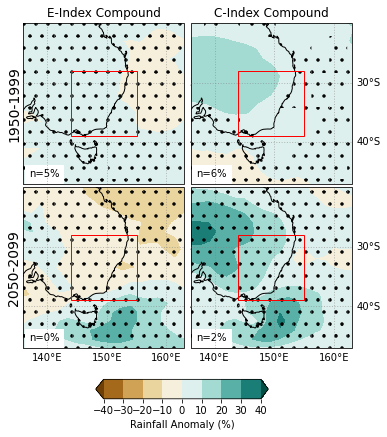

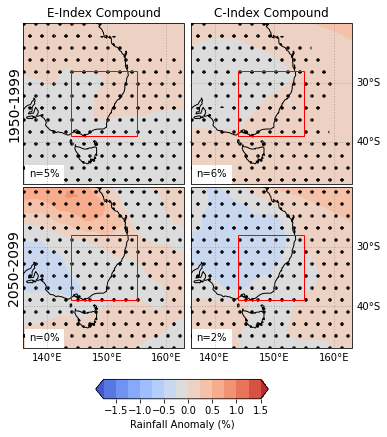

summer


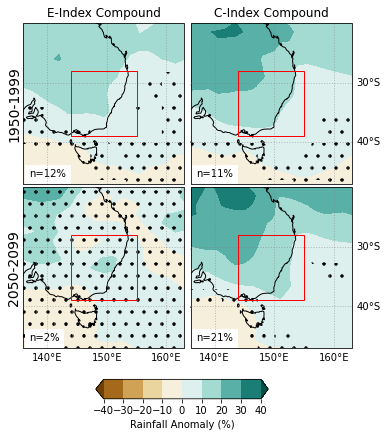

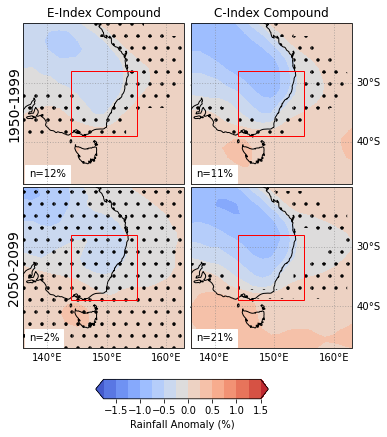

In [8]:
%run helpers/impactPlots.ipynb
for iFire in ['neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
            print(iSeason)

            axs=multiPlotter(
                prXr[iSeason.capitalize()+' Rain'], #sourceData
                allCompounds[
                    ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason]
                ].sel(fire=iFire,compound=['enso+sam','enso+iod','all3'],drop=True).any('compound'), #masks for event types
                ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason],
                cbarLabel='Rainfall Anomaly (%)'
            )
            axs[0].set_title('E-Index Compound')
            axs[1].set_title('C-Index Compound')


            plt.show()

            axs=multiPlotter(
                detrendTsXr[iSeason.capitalize()+' Temp'], #sourceData
                allCompounds[
                    ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason]
                ].sel(fire=iFire,compound=['enso+sam','enso+iod','all3'],drop=True).any('compound'), #masks for event types
                ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason],
                cbarLabel='Rainfall Anomaly (%)'
            )
            axs[0].set_title('E-Index Compound')
            axs[1].set_title('C-Index Compound')

            plt.show()


# How many are wetter/drier?

Calculate
- how many models means are wetter in C index events compared to E index events
- how many models have negative anoms for E and C index events

In [67]:
CWetter=dict()
ENeg=dict()
CNeg=dict()

for iFire in ['pos','neg']:
    CWetter['winter']=list()
    CWetter['summer']=list()
    ENeg['winter']=list()
    ENeg['summer']=list()
    CNeg['winter']=list()
    CNeg['summer']=list()
    for iModel in prXr.model.values:
        for iSeason in ['winter','summer']:
            eventAnoms=dict()
            for iIndex in ['eIndex','cIndex' ]:
                eventAnoms[iIndex]=domain(
                    prXr[iSeason.capitalize()+' Rain'].where(
                        allCompounds[iIndex+'DmiSam'+iSeason].sel(
                            compound=['enso+iod','enso+sam','all3'],
                            year=slice(1950,1999),
                            fire=iFire,
                            model=iModel,
                            drop=True
                            ).any('compound')
                        )
                    ).sel(model=iModel,drop=True).mean(['lat','lon','year'])
            CWetter[iSeason].append((eventAnoms['cIndex'].values)>(eventAnoms['eIndex'].values))
            ENeg[iSeason].append((eventAnoms['eIndex'].values)<0)
            CNeg[iSeason].append((eventAnoms['cIndex'].values)<0)

    print('C wetter than E, winter: ' + str(sum(CWetter['winter'])))
    print(sum(CWetter['summer']))
    print(sum(ENeg['winter']))
    print(sum(ENeg['summer']))
    print(sum(CNeg['winter']))
    print(sum(CNeg['summer']))

C wetter than E, winter: 12
20
31
31
37
32
C wetter than E, winter: 20
22
17
5
5
0


In [71]:
eventAnoms

<xarray.Dataset>
Dimensions:   (model: 37)
Coordinates:
  * model     (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    enso+iod  (model) float64 nan nan nan nan nan ... nan -0.4921 nan nan nan
    iod+sam   (model) float64 nan nan nan nan nan ... 17.48 10.14 nan nan nan
    enso+sam  (model) float64 17.29 2.688 10.03 7.241 ... 6.494 19.53 17.67
    all3      (model) float64 nan nan nan 5.151 ... 11.83 0.04766 20.46 4.943

winterPos


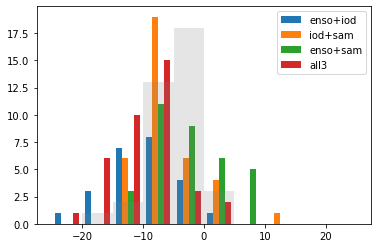

summerPos


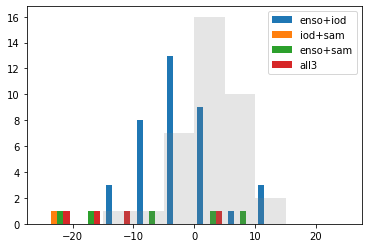

winterNeg


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


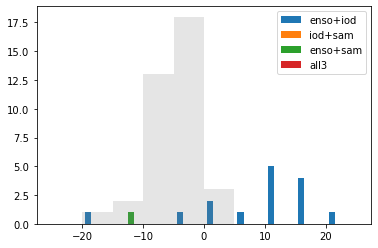

summerNeg


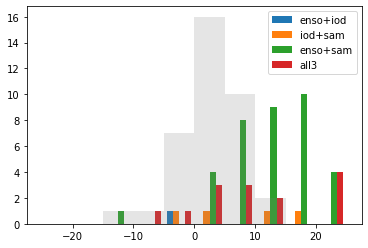

In [70]:
compounds=['enso+iod','iod+sam','enso+sam','all3']
import numpy as np
for iFire in ['pos','neg']:
    for iSeason in ['winter','summer']:
        print(iSeason+iFire.capitalize())
        eventAnoms=domain(prXr[iSeason.capitalize()+' Rain'].where(
                                allCompounds['ecCombinedDmiSam'+iSeason].sel(
                                    compound=compounds,
                                    year=slice(2050,2099),
                                    fire=iFire,
                                    drop=True
                                    )
                                )
                            ).to_dataset('compound').mean(['year','lat','lon'])

        n=plt.hist(
            [eventAnoms[iIndex].values.flatten() for iIndex in compounds],
            bins=np.arange(-25,26,5)
        )

        plt.legend(compounds)
        
        
        allYears=domain(
            prXr[iSeason.capitalize()+' Rain'].sel(year=slice(2050,2099))
        ).mean(['year','lat','lon'])
        
        n=plt.hist(
            allYears,
            bins=np.arange(-25,26,5), 
            alpha=0.2,
            color='grey'
        )
        
        plt.show()

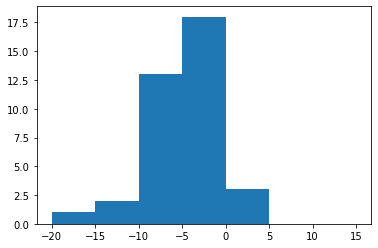

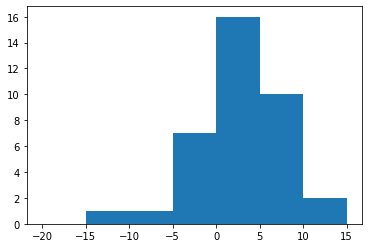

In [58]:
for iSeason in ['winter','summer']:
    allYears=domain(
        prXr[iSeason.capitalize()+' Rain'].sel(year=slice(2050,2099))
    ).mean(['year','lat','lon'])

    n=plt.hist(
        allYears,
        bins=range(-20,20,5)
    )

    plt.show()